# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed

Using TensorFlow backend.


In [3]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='Project_data'

##### Plotting

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [8]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

##### Sample Cropping

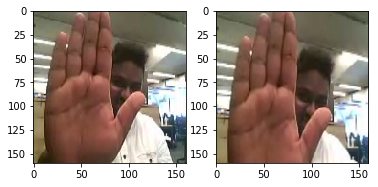

In [10]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [11]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [14]:
print("Memory utilization is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory utilization is 3.662109524011612 Gigs


##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - 82s 2s/step - loss: 1.6526 - categorical_accuracy: 0.3834 - val_loss: 1.6490 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.64896, saving model to model_init_2021-01-0409_18_44.911355/model-00001-1.66696-0.38462-1.64896-0.46000.h5
Epoch 2/2
34/34 [==============================] - 73s 2s/step - loss: 1.0982 - categorical_accuracy: 0.5762 - val_loss: 1.4238 - val_categorical_accuracy: 0.4800

Epoch 00002: val_loss improved from 1.64896 to 1.42377, saving model to model_init_2021-01-0409_18_44.911355/model-00002-1.07469-0.58220-1.42377-0.48000.h5


In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 96s 2s/step - loss: 1.4824 - categorical_accuracy: 0.4460 - val_loss: 1.3216 - val_categorical_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 1.32160, saving model to model_init_2021-01-0409_21_25.532310/model-00001-1.48839-0.44796-1.32160-0.60000.h5
Epoch 2/2
45/45 [==============================] - 87s 2s/step - loss: 0.9799 - categorical_accuracy: 0.6075 - val_loss: 1.0458 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss improved from 1.32160 to 1.04576, saving model to model_init_2021-01-0409_21_25.532310/model-00002-0.97585-0.61237-1.04576-0.59000.h5


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - 56s 2s/step - loss: 1.6245 - categorical_accuracy: 0.3914 - val_loss: 1.6885 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.68848, saving model to model_init_2021-01-0409_24_36.114032/model-00001-1.64520-0.39367-1.68848-0.40000.h5
Epoch 2/2
23/23 [==============================] - 44s 2s/step - loss: 1.1295 - categorical_accuracy: 0.5578 - val_loss: 1.0023 - val_categorical_accuracy: 0.5700

Epoch 00002: val_loss improved from 1.68848 to 1.00231, saving model to model_init_2021-01-0409_24_36.114032/model-00002-1.12544-0.55354-1.00231-0.57000.h5


- **Image resolution** and **number of frames** in sequence have a greater impact on training time than **batch_size** so we would be focusing on those parameters while adjusting our models
- We change the resoulution to 160*160 or 120*120 according the model performance

## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [19]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_22 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 10, 80, 80, 32)    128       
__________

In [21]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 74s 4s/step - loss: 1.4519 - categorical_accuracy: 0.4335 - val_loss: 6.7463 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 6.74626, saving model to model_init_2021-01-0409_26_24.290026/model-00001-1.45278-0.43137-6.74626-0.30000.h5
Epoch 2/15
17/17 [==============================] - 53s 3s/step - loss: 0.8709 - categorical_accuracy: 0.6619 - val_loss: 3.7775 - val_categorical_accuracy: 0.3900

Epoch 00002: val_loss improved from 6.74626 to 3.77749, saving model to model_init_2021-01-0409_26_24.290026/model-00002-0.87306-0.66214-3.77749-0.39000.h5
Epoch 3/15
17/17 [==============================] - 59s 3s/step - loss: 0.6858 - categorical_accuracy: 0.7286 - val_loss: 1.0510 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 3.77749 to 1.05099, saving model to model_init_2021-01-0409_26_24.290026/model-00003-0.68347-0.73152-1.05099-0.62000.h5
Epoch 4/15
17/17 [=

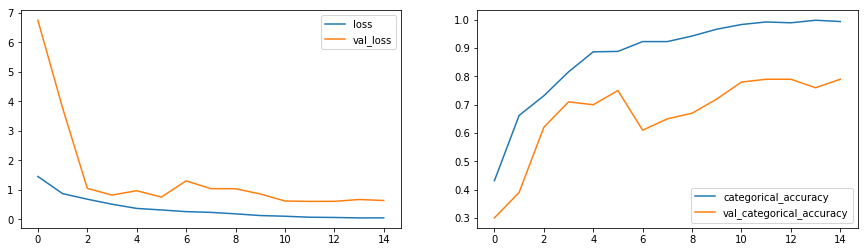

In [22]:
plot(history_model1)

We notice that the model is overfitting. Let's try to reduce the batch size and number of epochs.

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [23]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 10, 80, 80, 32)    128       
__________

In [24]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 143s 4s/step - loss: 1.8884 - categorical_accuracy: 0.3988 - val_loss: 2.5230 - val_categorical_accuracy: 0.4200

Epoch 00001: val_loss improved from inf to 2.52297, saving model to model_init_2021-01-0409_41_30.420126/model-00001-1.87195-0.40045-2.52297-0.42000.h5
Epoch 2/25
34/34 [==============================] - 129s 4s/step - loss: 1.4215 - categorical_accuracy: 0.5048 - val_loss: 1.9239 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss improved from 2.52297 to 1.92393, saving model to model_init_2021-01-0409_41_30.420126/model-00002-1.40510-0.50905-1.92393-0.43000.h5
Epoch 3/25
34/34 [==============================] - 134s 4s/step - loss: 1.2416 - categorical_accuracy: 0.5662 - val_loss: 1.5101 - val_categorical_accuracy: 0.5200

Epoch 00003: val_loss improved from 1.92393 to 1.51006, saving model to model_init_2021-01-0409_41_30.420126/model-00003-1.23380-0.57617-1.51006-0.52000.h5
Epoch 4/25
34/34

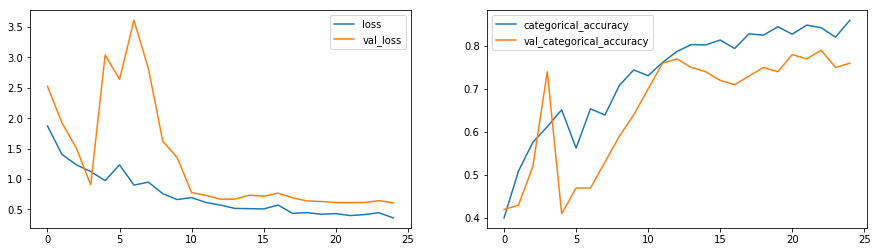

In [25]:
plot(history_model2)

##### We can see  validation loss improves only slightly after 10 epochs. 

#### Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [26]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_30 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 60, 60, 32)     128       
__________

In [28]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 96s 4s/step - loss: 2.1696 - categorical_accuracy: 0.3137 - val_loss: 1.1814 - val_categorical_accuracy: 0.5500

Epoch 00001: val_loss improved from inf to 1.18138, saving model to model_init_2021-01-0410_37_47.772903/model-00001-2.20121-0.31297-1.18138-0.55000.h5
Epoch 2/25
23/23 [==============================] - 84s 4s/step - loss: 1.5922 - categorical_accuracy: 0.4525 - val_loss: 0.8973 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.18138 to 0.89730, saving model to model_init_2021-01-0410_37_47.772903/model-00002-1.58858-0.44419-0.89730-0.60000.h5
Epoch 3/25
23/23 [==============================] - 88s 4s/step - loss: 1.4127 - categorical_accuracy: 0.4810 - val_loss: 0.8947 - val_categorical_accuracy: 0.6600

Epoch 00003: val_loss improved from 0.89730 to 0.89473, saving model to model_init_2021-01-0410_37_47.772903/model-00003-1.36976-0.49321-0.89473-0.66000.h5
Epoch 4/25
23/23 [=

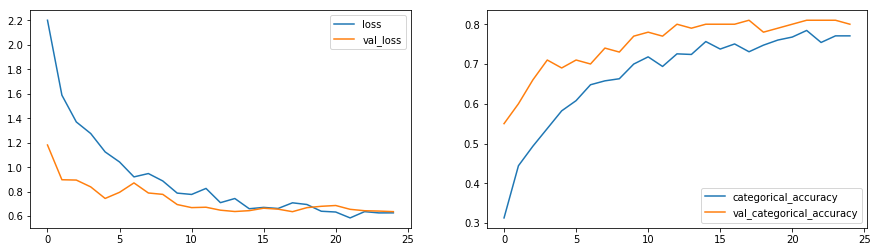

In [29]:
plot(history_model3)

Model has a great validation accuracy of 80% and training accuracy of 77% . Also we were able to reduce the parameter size by half of the earlier model. Now let us add more layers keeping the rest of the parameters constant to test if the training accuracy increases.

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [30]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_34 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [32]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 119s 3s/step - loss: 2.0188 - categorical_accuracy: 0.3745 - val_loss: 9.7406 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss improved from inf to 9.74056, saving model to model_init_2021-01-0411_14_56.934566/model-00001-2.03101-0.36727-9.74056-0.26000.h5
Epoch 2/25
34/34 [==============================] - 96s 3s/step - loss: 1.5305 - categorical_accuracy: 0.4853 - val_loss: 4.1600 - val_categorical_accuracy: 0.3400

Epoch 00002: val_loss improved from 9.74056 to 4.16000, saving model to model_init_2021-01-0411_14_56.934566/model-00002-1.53654-0.48492-4.16000-0.34000.h5
Epoch 3/25
34/34 [==============================] - 96s 3s/step - loss: 1.3228 - categorical_accuracy: 0.5224 - val_loss: 2.1827 - val_categorical_accuracy: 0.4900

Epoch 00003: val_loss improved from 4.16000 to 2.18267, saving model to model_init_2021-01-0411_14_56.934566/model-00003-1.27246-0.53544-2.18267-0.49000.h5
Epoch 4/25
34/34 [

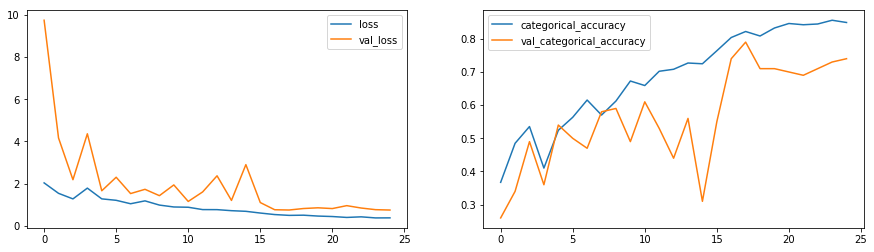

In [33]:
plot(history_model4)

We did not get an improvement in the training accuracy by adding more layers and we understand that more number of layers is not a solution to the problem. Now let us add some dropouts at the convolution layers to see if the accuracy increases

## Model 5 
### Adding dropout at convolution layers

In [34]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_42 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [36]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 110s 3s/step - loss: 1.7837 - categorical_accuracy: 0.3745 - val_loss: 5.4493 - val_categorical_accuracy: 0.3500

Epoch 00001: val_loss improved from inf to 5.44935, saving model to model_init_2021-01-0411_56_56.857810/model-00001-1.78989-0.36727-5.44935-0.35000.h5
Epoch 2/15
34/34 [==============================] - 97s 3s/step - loss: 1.2541 - categorical_accuracy: 0.5386 - val_loss: 2.7635 - val_categorical_accuracy: 0.4000

Epoch 00002: val_loss improved from 5.44935 to 2.76347, saving model to model_init_2021-01-0411_56_56.857810/model-00002-1.27804-0.52715-2.76347-0.40000.h5
Epoch 3/15
34/34 [==============================] - 97s 3s/step - loss: 1.1697 - categorical_accuracy: 0.5603 - val_loss: 1.9936 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss improved from 2.76347 to 1.99362, saving model to model_init_2021-01-0411_56_56.857810/model-00003-1.16717-0.56184-1.99362-0.42000.h5
Epoch 4/15
34/34 [

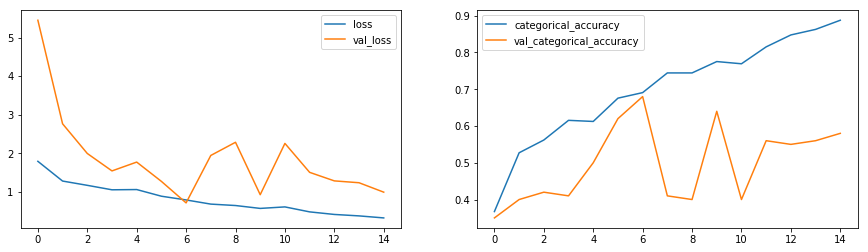

In [37]:
plot(history_model5)

We now notice that the model has started overfitting again. Let's reduce the number of parameters.

## Model 6 
### Reducing the number of parameters

In [38]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_49 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_50 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 8, 50, 50, 32)     128       
__________

In [40]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - 89s 3s/step - loss: 1.9193 - categorical_accuracy: 0.3385 - val_loss: 1.3513 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 1.35126, saving model to model_init_2021-01-0412_22_19.621773/model-00001-1.89824-0.33861-1.35126-0.51000.h5
Epoch 2/20
34/34 [==============================] - 76s 2s/step - loss: 1.2916 - categorical_accuracy: 0.5110 - val_loss: 1.1662 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss improved from 1.35126 to 1.16620, saving model to model_init_2021-01-0412_22_19.621773/model-00002-1.27135-0.51961-1.16620-0.59000.h5
Epoch 3/20
34/34 [==============================] - 84s 2s/step - loss: 1.0799 - categorical_accuracy: 0.5857 - val_loss: 1.0657 - val_categorical_accuracy: 0.6400

Epoch 00003: val_loss improved from 1.16620 to 1.06571, saving model to model_init_2021-01-0412_22_19.621773/model-00003-1.06540-0.59201-1.06571-0.64000.h5
Epoch 4/20
34/34 [==

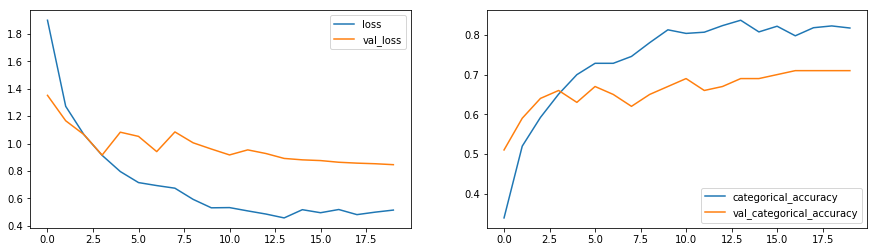

In [41]:
plot(history_model6)

Reducing the number of parameters helped the overfitting but the model accuracy has been compromised slightly so we conclude that Model4 was our best model so far using Conv3D. Now let's switch to CNN-LSTM models.

## Model 7 - CNN- LSTM Model

In [45]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [46]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [47]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 108s 3s/step - loss: 1.3995 - categorical_accuracy: 0.3819 - val_loss: 1.7101 - val_categorical_accuracy: 0.2800

Epoch 00001: val_loss improved from inf to 1.71015, saving model to model_init_2021-01-0413_03_44.686122/model-00001-1.40598-0.37481-1.71015-0.28000.h5
Epoch 2/20
34/34 [==============================] - 90s 3s/step - loss: 1.0602 - categorical_accuracy: 0.5666 - val_loss: 1.0774 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.71015 to 1.07735, saving model to model_init_2021-01-0413_03_44.686122/model-00002-1.07804-0.55581-1.07735-0.55000.h5
Epoch 3/20
34/34 [==============================] - 99s 3s/step - loss: 0.9638 - categorical_accuracy: 0.6111 - val_loss: 1.1201 - val_categorical_accuracy: 0.5100

Epoch 00003: val_loss did not improve from 1.07735
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.8745 - categorical_accuracy: 0.6637 - val_loss: 

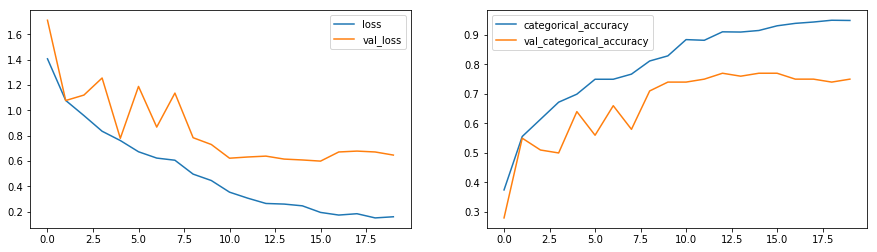

In [48]:
plot(history_model8)

The validation accuracy is around 74%, but we notice that the model is overfitting. Let's augment the data with ***slight rotation*** and run the same set of models again.

## Let's apply some data augmentation & check the model performance.

In [12]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

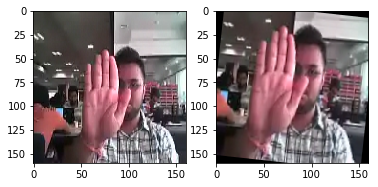

In [13]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 8 with Augmentation
### Reducing network parameters - Similar to Model 6

In [18]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=100,image_width=100)
conv_3d9.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d9_model=conv_3d9.define_model(dense_neurons=128,dropout=0.25)
conv_3d9_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 50, 50, 32)     128       
__________

In [54]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - 84s 2s/step - loss: 1.7943 - categorical_accuracy: 0.3587 - val_loss: 1.2425 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2021-01-0413_39_38.374293/model-00001-1.77900-0.36350-1.24251-0.54000.h5
Epoch 2/25
34/34 [==============================] - 70s 2s/step - loss: 1.2948 - categorical_accuracy: 0.5055 - val_loss: 1.0604 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2021-01-0413_39_38.374293/model-00002-1.26950-0.51810-1.06043-0.56000.h5
Epoch 3/25
34/34 [==============================] - 79s 2s/step - loss: 1.0629 - categorical_accuracy: 0.6045 - val_loss: 1.0164 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2021-01-0413_39_38.374293/model-00003-1.04664-0.60709-1.01640-0.65000.h5
Epoch 4/25
34/34 [==============================] - 79s 2s/step - loss: 0.8782 - categorical_accuracy: 0.6553 - val_loss: 0.9706 - val_categorica

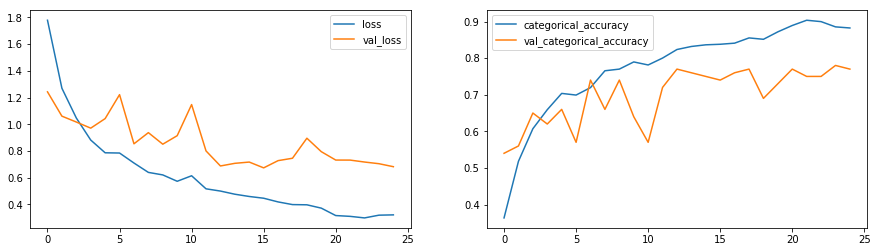

In [55]:
plot(history_model9)

## Model 9 - Transfer Learning with GRU and training all weights

In [14]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [16]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
__________

In [17]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model12=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 99s 746ms/step - loss: 1.2098 - categorical_accuracy: 0.5203 - val_loss: 0.8673 - val_categorical_accuracy: 0.6300

Epoch 00001: saving model to model_init_2021-01-0415_24_29.976388/model-00001-1.20990-0.52036-0.86727-0.63000.h5
Epoch 2/20
133/133 [==============================] - 82s 615ms/step - loss: 0.6435 - categorical_accuracy: 0.7551 - val_loss: 0.4810 - val_categorical_accuracy: 0.8400

Epoch 00002: saving model to model_init_2021-01-0415_24_29.976388/model-00002-0.64400-0.75490-0.48099-0.84000.h5
Epoch 3/20
133/133 [==============================] - 85s 640ms/step - loss: 0.4596 - categorical_accuracy: 0.8293 - val_loss: 0.4073 - val_categorical_accuracy: 0.8100

Epoch 00003: saving model to model_init_2021-01-0415_24_29.976388/model-00003-0.46079-0.82881-0.40735-0.81000.h5
Epoch 4/20
133/133 [==============================] - 84s 630ms/step - loss: 0.4067 - categorical_accuracy: 0.8549 - val_loss: 0.

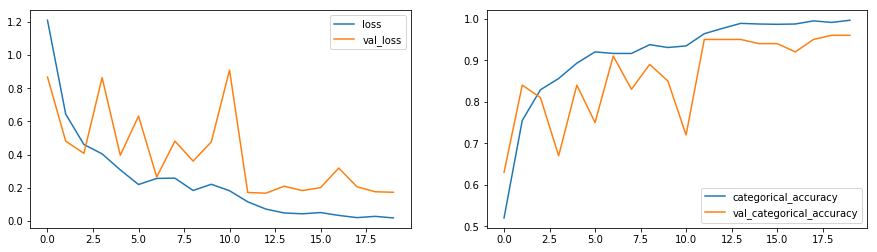

In [18]:
plot(history_model12)

We are able to achieve Training Accuracy: 0.96 and Validation Accuracy: 0.95 at epoch 11 and this seems to be an ideal fit.


# Consolidated Final Models

We finalized the CNN LSTM with GRU model using Transfer Learning after adding drop-out convolution layers, reducing the number of parameters as well as adjusting the hyper-parameters on our base model. The final model:

•	Returned a training accuracy of 96% and a validation accuracy of 95%

•	Had a higher number of trainable parameters: 3,668,933

# Loading model and Testing

In [19]:
import time
from keras.models import load_model
model = load_model('model-00011-0.18195-0.93439-0.90906-0.72000.h5')

In [24]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [25]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [26]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 2 1 3 3 2 2 4 1 1 2 2 0 2 0 1 1 3 3 3]
